In [1]:
# Sentiment algorithm 3. Sequence of lemmas and POS-tag as multiple features input and multi sentiment classification of sentence as output

# Model is saved in saved_models/model_name/model_variant.h5
# Run history is saved in logged_models/model_name sorted by model_variants and run-datetime
# Runs can be viewed using tensorboard: tensorboard --logdir=PATH --port=6006
# Example given: tensorboard --logdir=C:\BAC\Ezra\sentiment\models\logged_models\sent_algo_1 --port=6006
model_name = 'sent_algo_4'
model_variant = 'base_v2'

training_size = 3000000
test_size = 1000000

In [2]:
# SETUP IMPORTS
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import pandas as pd
import numpy as np
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model
import time
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from keras import callbacks
from keras import Input

%reload_ext autoreload
%autoreload 2
from helpers.sentiment_functions import gender_seq_to_single
from helpers.sentiment_functions import equal_genders
from helpers.sentiment_functions import encode_feature
from helpers.sentiment_functions import plot_sentence_lengths
from helpers.sentiment_functions import plot_confusion_matrix_multi
from helpers.sentiment_functions import get_metrics
from helpers.sentiment_functions import round_list
from helpers.sentiment_functions import encode_list
from helpers.sentiment_functions import one_hot_list
from helpers.sentiment_functions import xai_multi

pd.set_option('display.max_columns', 10, 'display.width', 10, 'display.max_colwidth', 20, 'display.max_rows',100)

In [3]:
# LOAD DATASET
df = pd.read_json('../datasets/sentiment_corpus.json')
print("Corpus sample size is:", len(df))

print(training_size, "samples are taken from the head for training")
print(test_size, "samples are taken from the tail for test")

# We take from the head for training data and tail for test data
# This is done since the last 25% of the corpus is not fitted on the polarity dict, thereby preventing overfitting
train_data = df.head(training_size)
test_data = df.tail(test_size)

train_data

Corpus sample size is: 4970467
3000000 samples are taken from the head for training
1000000 samples are taken from the tail for test


,Sentence #,Word,Lemma,POS,Polarity,Gender
0,1,organizations,organization,NOUN,-0.223025,F
1,1,decided,decide,VERB,-0.039008,F
2,1,drop,drop,VERB,-0.058436,F
3,1,women,woman,NOUN,0.272143,F
4,1,accused,accuse,VERB,0.006282,F
...,...,...,...,...,...,...
2999995,404384,cool,cool,ADJ,0.037064,F
2999996,404384,factors,factor,NOUN,-0.055300,F
2999997,404384,like,like,ADP,-0.129606,F
2999998,404384,pore,pore,NOUN,0.000000,F


In [4]:
# GROUP-BY SENTENCE NUMBER 
train_data = train_data.groupby(['Sentence #'],as_index=False)['Word', 'Lemma', 'POS', 'Polarity', 'Gender'].agg(lambda x: list(x))
test_data = test_data.groupby(['Sentence #'],as_index=False)['Word', 'Lemma', 'POS', 'Polarity', 'Gender'].agg(lambda x: list(x))

train_data['Gender'] = gender_seq_to_single(train_data['Gender'])
test_data['Gender'] = gender_seq_to_single(test_data['Gender'])
train_data

C:\Users\hanse\AppData\Local\Temp/ipykernel_6812/3370681660.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  train_data = train_data.groupby(['Sentence #'],as_index=False)['Word', 'Lemma', 'POS', 'Polarity', 'Gender'].agg(lambda x: list(x))
C:\Users\hanse\AppData\Local\Temp/ipykernel_6812/3370681660.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  test_data = test_data.groupby(['Sentence #'],as_index=False)['Word', 'Lemma', 'POS', 'Polarity', 'Gender'].agg(lambda x: list(x))


,Sentence #,Word,Lemma,POS,Polarity,Gender
0,1,"[organizations, ...","[organization, d...","[NOUN, VERB, VER...",[-0.223024829414...,F
1,2,"[Women, previous...","[woman, previous...","[NOUN, ADV, VERB...",[0.2721428399909...,F
2,3,"[response, alleg...","[response, alleg...","[NOUN, NOUN, PRO...",[-0.028053754978...,F
3,4,"[aware, allegati...","[aware, allegati...","[ADJ, NOUN, PROPN]",[-0.015715441394...,F
4,5,"[point, Visa, su...","[point, Visa, su...","[NOUN, PROPN, VE...",[-0.228729956550...,F
...,...,...,...,...,...,...
362024,404378,"[Philosophy, Hel...","[philosophy, hel...","[NOUN, VERB, NOUN]","[0.0, -0.2512493...",F
362025,404379,"[Philosophy, gem...","[Philosophy, gem...","[PROPN, NOUN, AD...","[0.0, 0.0, -0.19...",F
362026,404381,"[Benefit, POREfe...","[benefit, porefe...","[VERB, NOUN, NOU...",[-0.167289610994...,F
362027,404383,[Pores],[Pores],[PROPN],[0.0],F


In [5]:
# SHUFFLE TRAINING AND TEST DATA
train_data = train_data.sample(frac=1).reset_index(drop=True)
test_data = test_data.sample(frac=1).reset_index(drop=True)
train_data

,Sentence #,Word,Lemma,POS,Polarity,Gender
0,292925,"[Especially, sta...","[especially, sta...","[ADV, VERB, NOUN...",[-0.040137214864...,M
1,69430,"[ve, seen, happe...","[ve, see, happen...","[AUX, VERB, VERB...","[0.0, -0.0624820...",F
2,213080,"[Use, knowledge,...","[use, knowledge,...","[VERB, NOUN, VER...",[-0.158575311190...,M
3,310414,[firm],[firm],[ADJ],[-0.174347980730...,M
4,378596,"[real, issues, r...","[real, issue, re...","[ADJ, NOUN, ADJ,...",[-0.096857085481...,M
...,...,...,...,...,...,...
362024,151736,"[collaboration, ...","[collaboration, ...","[NOUN, VERB]","[0.0, -0.1589070...",F
362025,327214,[Prediction],[prediction],[NOUN],[0.0],M
362026,223596,"[web, hasn, kill...","[web, hasn, kill...","[NOUN, NOUN, VER...",[-0.006099405604...,M
362027,226341,"[love, romance, ...","[love, romance, ...","[NOUN, NOUN, VER...",[0.1110567439853...,F


<AxesSubplot:>

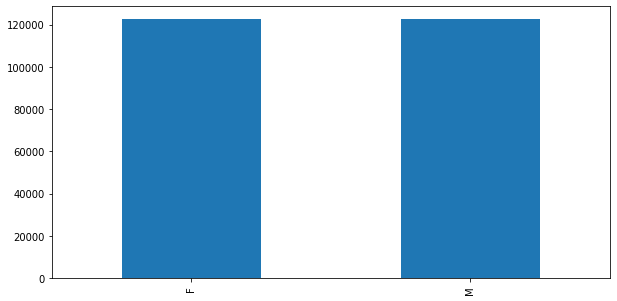

In [6]:
# EQUAL GENDER SAMPLES TO PREVENT BIAS
train_data = equal_genders(train_data)
test_data = equal_genders(test_data)

train_data["Gender"].value_counts().plot(kind="bar", figsize=(10,5))

No handles with labels found to put in legend.


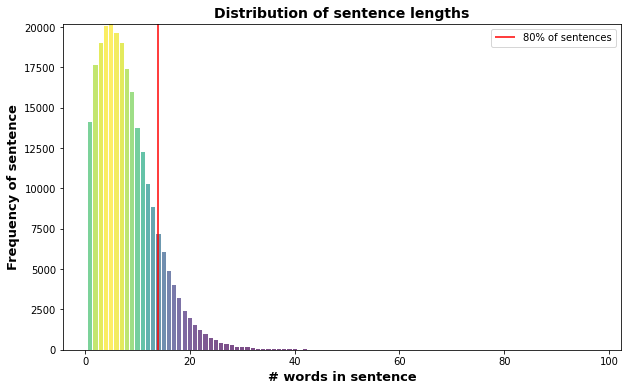

Decision boundary / 80 pct of sentence lengths is: 14


In [7]:
# VISUALIZE SENTENCE LENGTHS AND DECISION BOUNDARY
decision_boundary = plot_sentence_lengths(train_data)
print("Decision boundary / 80 pct of sentence lengths is:", decision_boundary)

In [8]:
# ONE-HOT TARGET (GENDER)
classes = [-1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
n_unique_classes = len(classes)

pol_to_enc = {
    -1.0: 1,
    -0.9: 2,
    -0.8: 3,
    -0.7: 4,
    -0.6: 5,
    -0.5: 6,
    -0.4: 7,
    -0.3: 8,
    -0.2: 9,
    -0.1: 10,
    0.0: 11,
    0.1: 12,
    0.2: 13,
    0.3: 14,
    0.4: 15,
    0.5: 16,
    0.6: 17,
    0.7: 18,
    0.8: 19,
    0.9: 20,
    1.0: 21
}

train_pols_rounded = round_list(train_data['Polarity'])
train_pols_encoded = encode_list(train_pols_rounded, pol_to_enc)
y_train = one_hot_list(train_pols_encoded, n_unique_classes)

test_pols_rounded = round_list(test_data['Polarity'])
test_pols_encoded = encode_list(test_pols_rounded, pol_to_enc)
y_test = one_hot_list(test_pols_encoded, n_unique_classes)


print("Unique polarities:", [classes])
print("Unique polarities:", encode_list([classes], pol_to_enc))

print("\nTraining data example polarity sequence:", train_data['Polarity'][:1].tolist())
print("Training data example polarity sequence rounded:", train_pols_rounded[0])
print("Training data example polarity sequence encoded:", train_pols_encoded[0])
print("Training data example polarity sequence one-hot:", y_train[0])

print("\nTest data example polarity sequence:", test_data['Polarity'][:1].tolist())
print("Test data example polarity sequence rounded:", test_pols_rounded[0])
print("Test data example polarity sequence encoded:", test_pols_encoded[0])
print("Test data example polarity sequence one-hot:", y_test[0])

Unique polarities: [[-1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]]
Unique polarities: [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]]

Training data example polarity sequence: [[0.0, -0.062482098066628, -0.08213922234331, 0.0]]
Training data example polarity sequence rounded: [0.0, -0.1, -0.1, 0.0]
Training data example polarity sequence encoded: [11, 10, 10, 11]
Training data example polarity sequence one-hot: [array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.], dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.], dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.], dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.], dtype=float32)]

Test data example polar

In [9]:
# ENCODE FEATURES TO INTEGERS, EQUAL LENGTHS AND PAD
# Inspired by: https://machinelearningmastery.com/prepare-text-data-deep-learning-keras/
train_data['Lemma_enc'], test_data['Lemma_enc'], vocab_size_lemma = encode_feature(train_data['Lemma'], test_data['Lemma'])
train_data['POS_enc'], test_data['POS_enc'], vocab_size_pos = encode_feature(train_data['POS'], test_data['POS'])

trunc_type = 'post'
padding_type = 'post'
max_len = decision_boundary

X_train_lemma = pad_sequences(train_data['Lemma_enc'], dtype='float32', padding=padding_type, truncating=trunc_type, maxlen=max_len)
X_train_pos = pad_sequences(train_data['POS_enc'], dtype='float32', padding=padding_type, truncating=trunc_type, maxlen=max_len)

X_test_lemma = pad_sequences(test_data['Lemma_enc'], dtype='float32', padding=padding_type, truncating=trunc_type, maxlen=max_len)
X_test_pos = pad_sequences(test_data['POS_enc'], dtype='float32', padding=padding_type, truncating=trunc_type, maxlen=max_len)

y_train = pad_sequences(y_train, dtype='float32', padding=padding_type, truncating=trunc_type, maxlen=max_len)
y_test = pad_sequences(y_test, dtype='float32', padding=padding_type, truncating=trunc_type, maxlen=max_len)

In [10]:
# DEFINING KERAS CALLBACKS

# Borrowed from: https://www.geeksforgeeks.org/choose-optimal-number-of-epochs-to-train-a-neural-network-in-keras/
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)

root_logdir = os.path.join(os.curdir, "./logged_models/" + model_name + '/' + model_variant)
def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_log_dir = get_run_logdir()
file_writer = tf.summary.create_file_writer(run_log_dir + "/metrics")
file_writer.set_as_default()

tensorboard_cb = tf.keras.callbacks.TensorBoard(run_log_dir)

my_callbacks = [earlystopping, tensorboard_cb]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
lemma_input (InputLayer)        [(None, 14)]         0                                            
__________________________________________________________________________________________________
POS_input (InputLayer)          [(None, 14)]         0                                            
__________________________________________________________________________________________________
lemma_embedding (Embedding)     (None, 14, 128)      5341312     lemma_input[0][0]                
__________________________________________________________________________________________________
POS_embedding (Embedding)       (None, 14, 128)      2304        POS_input[0][0]                  
______________________________________________________________________________________________

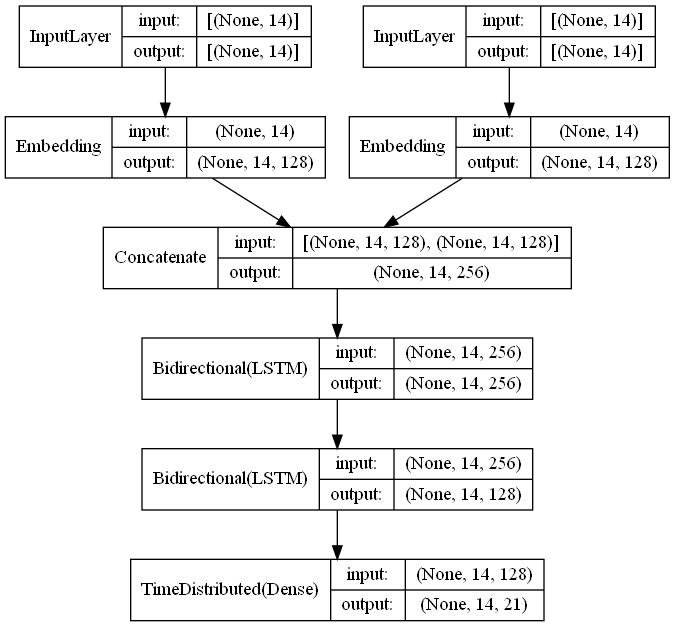

In [11]:
# DEFINING AND PLOTTING MODEL
embedding_dim = 128

lemma_input = Input(shape=(max_len), name='lemma_input')
pos_input = Input(shape=(max_len), name='POS_input')

lemma_embedding = layers.Embedding(vocab_size_lemma+1, embedding_dim, input_length=max_len, name="lemma_embedding", mask_zero=True)(lemma_input)
pos_embedding = layers.Embedding(vocab_size_pos+1, embedding_dim, input_length=max_len, name="POS_embedding")(pos_input)

concat = layers.Concatenate()([lemma_embedding, pos_embedding])

bidir_1 = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))(concat)

bidir_2 = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(bidir_1)

output = layers.TimeDistributed(layers.Dense(n_unique_classes, activation="softmax", name='output'))(bidir_2)

model = keras.Model(inputs=[lemma_input, pos_input], outputs=[output])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # cross entropy loss chapter 4 HOML - categorial crossentropy because to_categorial 

model.summary()

plot_model(model, show_shapes=True, show_layer_names=False)

In [12]:
# FITTING MODEL

history = model.fit([X_train_lemma, X_train_pos], y_train, epochs=20, callbacks=my_callbacks, validation_split=0.2)

Epoch 1/20
6126/6126 [==============================] - 729s 117ms/step - loss: 0.0314 - accuracy: 0.9838 - val_loss: 0.0017 - val_accuracy: 0.9993
Epoch 2/20
6126/6126 [==============================] - 770s 126ms/step - loss: 0.0015 - accuracy: 0.9992 - val_loss: 0.0015 - val_accuracy: 0.9993
Epoch 3/20
6126/6126 [==============================] - 776s 127ms/step - loss: 0.0012 - accuracy: 0.9993 - val_loss: 0.0015 - val_accuracy: 0.9993
Epoch 4/20
6126/6126 [==============================] - 809s 132ms/step - loss: 9.5034e-04 - accuracy: 0.9994 - val_loss: 0.0015 - val_accuracy: 0.9992
Epoch 5/20
6126/6126 [==============================] - 958s 156ms/step - loss: 7.6426e-04 - accuracy: 0.9995 - val_loss: 0.0016 - val_accuracy: 0.9993
Epoch 6/20
6126/6126 [==============================] - 815s 133ms/step - loss: 5.6568e-04 - accuracy: 0.9997 - val_loss: 0.0020 - val_accuracy: 0.9991
Epoch 7/20
6126/6126 [==============================] - 758s 124ms/step - loss: 4.2591e-04 - accurac

red is training, blue is validation


<Figure size 432x288 with 0 Axes>

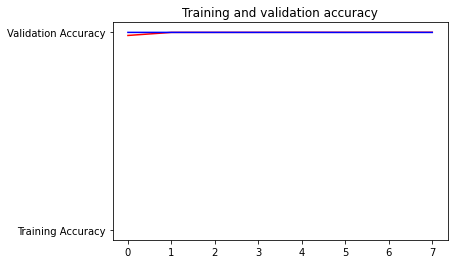

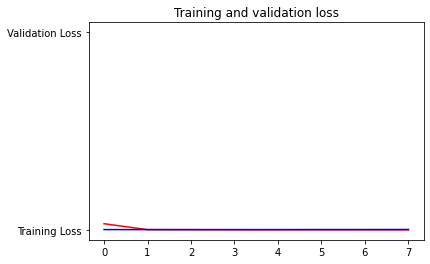

<Figure size 432x288 with 0 Axes>

In [13]:
# PLOTTING HISTORY OF FITTING
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs=range(len(acc))
plt.plot(epochs, acc, 'r', 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', 'Validation Accuracy')
plt.title('Training and validation accuracy')
plt.figure()
plt.plot(epochs, loss, 'r', 'Training Loss')
plt.plot(epochs, val_loss, 'b', 'Validation Loss')
plt.title('Training and validation loss')

print("red is training, blue is validation")
plt.figure()

In [14]:
# SAVING MODEL
model.save('saved_models/' + model_name + '/' + model_variant + '.h5')
model.save('saved_models/' + model_name + '/' + model_variant)

INFO:tensorflow:Assets written to: saved_models/sent_algo_4/base_v2\assets


INFO:tensorflow:Assets written to: saved_models/sent_algo_4/base_v2\assets
